In [1]:
# Load and mine the uploaded COTS program PDF, then build a keyword co-occurrence network image.
import re
from collections import Counter, defaultdict
from itertools import combinations

import matplotlib.pyplot as plt
import networkx as nx

# --- 1) Load text from the PDF ---
from pathlib import Path


Looking for PDF at: C:\Users\JakeCho\Projects\Conferences\COTS2025Nov\COTS 2025 Conference Program.pdf
PDF exists: True
📊 Found 237 keywords from 3676 unique words
🎯 Top 20 most frequent keywords:
    1. test                 (273 occurrences)
    2. security             (217 occurrences)
    3. testing              (103 occurrences)
    4. ai                   ( 73 occurrences)
    5. exam                 ( 72 occurrences)
    6. data                 ( 63 occurrences)
    7. response             ( 61 occurrences)
    8. integrity            ( 55 occurrences)
    9. items                ( 50 occurrences)
   10. location             ( 48 occurrences)
   11. methods              ( 46 occurrences)
   12. assessment           ( 46 occurrences)
   13. detection            ( 45 occurrences)
   14. assessments          ( 43 occurrences)
   15. programs             ( 39 occurrences)
   16. study                ( 38 occurrences)
   17. cheating             ( 38 occurrences)
   18. program       

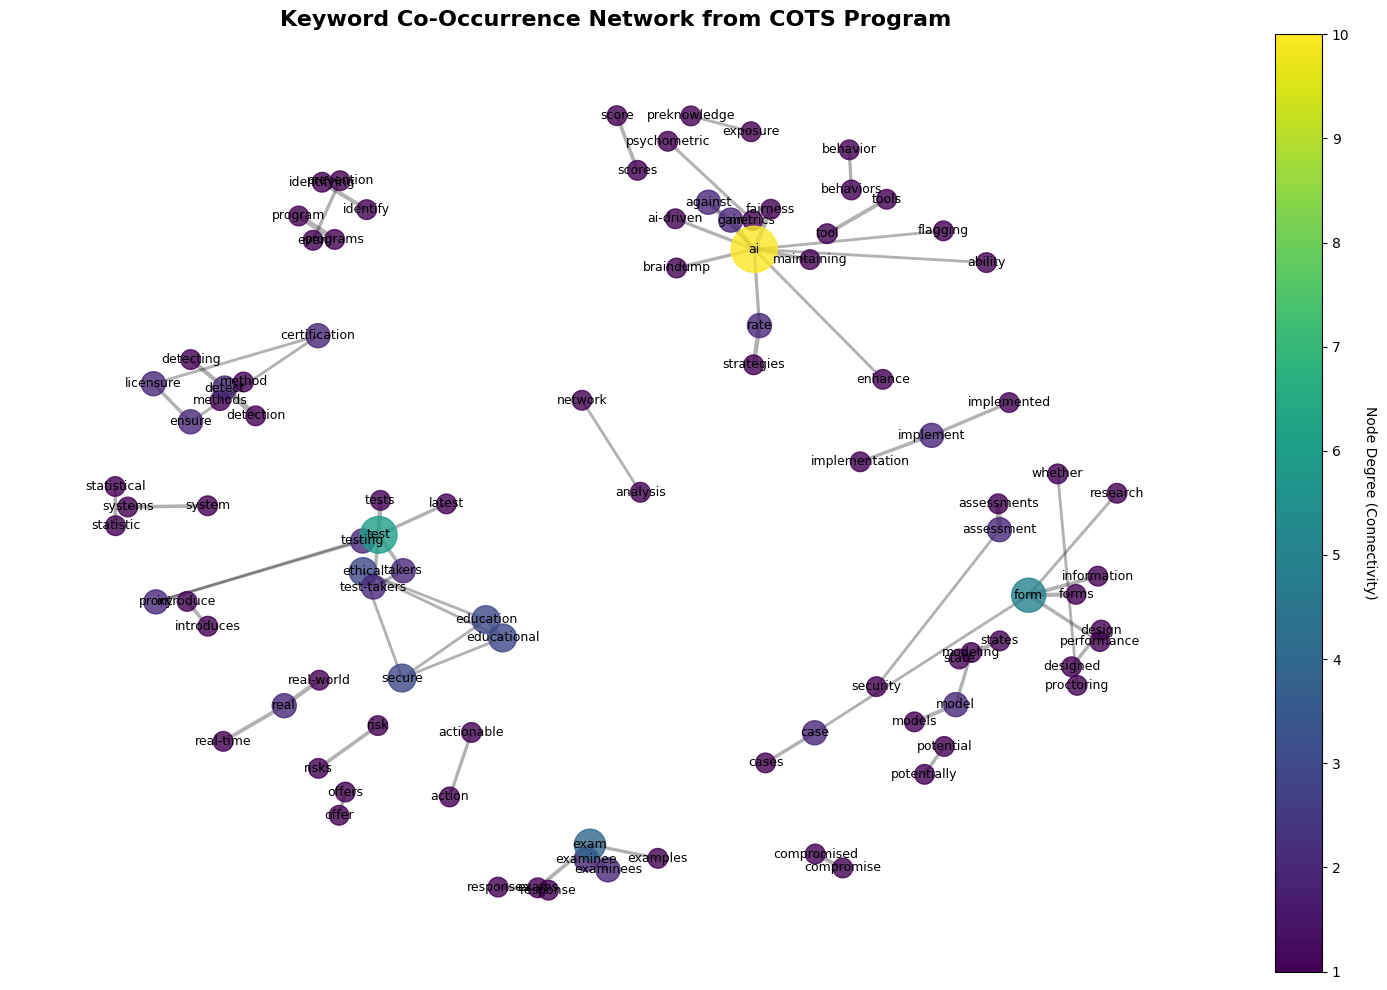

In [21]:

pdf_path = Path(r"C:\Users\JakeCho\Projects\Conferences\COTS2025Nov\COTS 2025 Conference Program.pdf")
print(f"Looking for PDF at: {pdf_path}")
print(f"PDF exists: {pdf_path.exists()}")

# Try a lightweight text extraction; fall back gracefully if library missing
text = ""
try:
    import PyPDF2
    with open(pdf_path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            # extract_text can be None; handle safely
            page_text = page.extract_text() or ""
            text += "\n" + page_text
except Exception as e:
    text = ""

# If nothing extracted, stop early with a message embedded in the figure
if not text.strip():
    fig = plt.figure(figsize=(8, 4))
    plt.axis("off")
    plt.text(0.5, 0.5, "Could not extract text from the PDF.\n"
                       "Please upload the article as a text or Word file.",
             ha="center", va="center", fontsize=14)
    out_path = r"C:\Users\JakeCho\Projects\Conferences\COTS2025Nov\text_network.png"
    plt.savefig(out_path, bbox_inches="tight", dpi=200)
    print(f"Saved message image to {out_path}")
else:
    # --- 2) Basic preprocessing ---
    # Keep only ASCII letters, digits, ampersands, spaces, and separators; lowercase
    clean = re.sub(r"[^A-Za-z0-9&\-\n ]+", " ", text)
    clean = re.sub(r"\s+", " ", clean)
    clean = clean.lower()
    
    # Split into "lines" using original newlines (coarser chunks help co-occurrence)
    lines = text.split("\n")
    
    # --- 3) Keyword extraction & co-occurrence ---
    # Simple: find words that appear frequently enough to be "keywords"
    all_tokens = clean.split()
    word_counts = Counter(all_tokens)
    
    # Comprehensive stop words list - filter out common words and non-content terms
    common_stops = {
        # Articles, pronouns, conjunctions
        "the", "a", "an", "and", "or", "of", "in", "on", "for", "to", "with", "is", "at", "by", "from",
        "as", "that", "this", "it", "be", "are", "was", "were", "will", "can", "has", "have", "had",
        "what", "which", "who", "when", "where", "why", "how", "all", "each", "every", "both", "few",
        "some", "any", "most", "other", "such", "than", "then", "them", "their", "there", "these", "those",
        "they", "been", "being", "into", "just", "only", "over", "same", "such", "very", "also", "but",
        "not", "may", "would", "could", "should", "our", "your", "out", "up", "down", "about", "after", "before",
        "off", "between", "under", "again", "further", "once", "here", "both", "however", "thus", "therefore",
        
        # Event/presentation related (not themes)
        "session", "sessions", "presentation", "presentations", "speaker", "speakers", "talk", "talks",
        "conference", "workshop", "panel", "panelist", "panelists", "moderator", "chair", "keynote",
        "abstract", "paper", "papers", "proceedings", "audience", "attendees", "room", "hall", "venue",
        
        # Generic action/process words (not specific themes)
        "approach", "using", "through", "based", "make", "making", "take", "taking", "give", "giving",
        "show", "showing", "provide", "providing", "include", "including", "present", "presenting",
        "discuss", "discussing", "explore", "exploring", "examine", "examining", "consider", "considering",
        "understand", "understanding", "learn", "learning", "teach", "teaching", "share", "sharing",
        "work", "working", "develop", "developing", "create", "creating", "build", "building",
        
        # Generic descriptors
        "more", "recent", "new", "old", "good", "better", "best", "high", "low", "large", "small",
        "different", "various", "several", "multiple", "many", "much", "less", "most", "other",
        "general", "specific", "particular", "certain", "important", "main", "major", "key",
        
        # Time references
        "year", "years", "month", "months", "day", "days", "time", "times", "today", "tomorrow",
        "past", "future", "current", "now", "later", "during", "since", "until", "while",
        
        # Numbers and ordinals (often noise)
        "first", "second", "third", "fourth", "fifth", "one", "two", "three", "four", "five",
        
        # Program structure words
        "part", "section", "chapter", "page", "line", "item", "point", "note", "table", "figure"
    }
    
    # Comprehensive person names list - first names, last names, and combinations
    person_names = {
        # First names
        "john", "paul", "david", "steve", "marc", "jake", "sarah", "rachel", "isabel", "isabelle", "carol",
        "harry", "bryan", "craig", "walt", "timothy", "jarret", "samit", "sergio", "camille", "kylie",
        "chen", "rose", "brent", "michael", "robert", "james", "mary", "jennifer", "linda", "patricia",
        "richard", "joseph", "thomas", "charles", "daniel", "matthew", "anthony", "mark", "donald",
        "steven", "andrew", "kenneth", "kevin", "brian", "george", "edward", "ronald", "timothy",
        "jason", "jeffrey", "ryan", "jacob", "gary", "nicholas", "eric", "jonathan", "stephen",
        "larry", "justin", "scott", "brandon", "benjamin", "samuel", "frank", "gregory", "raymond",
        "alexander", "patrick", "jack", "dennis", "jerry", "tyler", "aaron", "jose", "adam", "henry",
        "nathan", "douglas", "zachary", "peter", "kyle", "walter", "ethan", "jeremy", "harold",
        "keith", "christian", "roger", "noah", "gerald", "carl", "terry", "sean", "austin", "arthur",
        
        # Last names found in PDFs
        "olson", "drane", "dyer", "iness", "thompson", "gomey", "gorney", "gonthier", "hastings",
        "weinstein", "foster", "ritz", "toton", "krent", "threat", "hutcher", "schoenig", "addicott",
        "smith", "johnson", "williams", "brown", "jones", "garcia", "miller", "davis", "rodriguez",
        "martinez", "hernandez", "lopez", "gonzalez", "wilson", "anderson", "taylor", "moore",
        "jackson", "martin", "lee", "perez", "white", "harris", "sanchez", "clark", "ramirez",
        "lewis", "robinson", "walker", "young", "allen", "king", "wright", "scott", "torres",
        "nguyen", "hill", "flores", "green", "adams", "nelson", "baker", "hall", "rivera",
        "campbell", "mitchell", "carter", "roberts", "gomez", "phillips", "evans", "turner"
    }
    
    # Higher threshold to focus on main themes - set to 8 for clearest themes
    keyword_threshold = 8
    
    # Keywords to always include (AI/LLM related terms) - these should be kept even with 1 occurrence
    priority_keywords = {"ai", "chatgpt", "gpt", "llm", "llms", "generative"}
    
    # Build keyword set: include priority keywords if they appear at least once, others need threshold
    keywords = set()
    for w, cnt in word_counts.items():
        # Special handling for AI-related terms - always include if they appear
        if w.lower() in priority_keywords and cnt >= 1:
            keywords.add(w)
        # For other keywords, apply length and filters
        elif len(w) >= 4 and w not in common_stops and w not in person_names:
            if cnt >= keyword_threshold:
                keywords.add(w)
    
    print(f"📊 Found {len(keywords)} keywords from {len(word_counts)} unique words")
    print(f"🎯 Top 20 most frequent keywords:")
    keyword_freq = {k: word_counts[k] for k in keywords if k in word_counts}
    for i, (word, count) in enumerate(sorted(keyword_freq.items(), key=lambda x: x[1], reverse=True)[:20], 1):
        print(f"   {i:2d}. {word:20s} ({count:3d} occurrences)")
    
    # Co-occurrence edges (if two keywords appear in same line, that's a link)
    edge_counts = defaultdict(int)
    for line_text in lines:
        line_lower = line_text.lower()
        # Which keywords appear in this line?
        present = [kw for kw in keywords if kw in line_lower]
        # Increment edge for each pair
        for (a, b) in combinations(present, 2):
            pair = tuple(sorted([a, b]))
            edge_counts[pair] += 1
    
    # --- 4) Build the graph using networkx (more flexible sizing & layout) ---
    G = nx.Graph()
    # Add keywords as nodes
    for kw in keywords:
        G.add_node(kw)
    
    # Add edges for co-occurrences (filter out very weak edges if desired)
    min_cooccur = 1  # you can raise this if you only want strong edges
    for (node_a, node_b), weight in edge_counts.items():
        if weight >= min_cooccur:
            G.add_edge(node_a, node_b, weight=weight)
    
    # Remove isolated nodes if needed
    isolates = list(nx.isolates(G))
    G.remove_nodes_from(isolates)
    
    # --- 5) Layout & drawing ---
    fig, ax = plt.subplots(figsize=(14, 10))
    # Force-directed layout for clarity
    pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)
    
    # Node sizes based on their degree (how many connections they have)
    degrees = dict(G.degree())
    node_sizes = [degrees[n]*100 + 100 for n in G.nodes()]
    
    # Node colors based on degree (connectivity) - use a colormap
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    
    degree_values = [degrees[n] for n in G.nodes()]
    max_degree = max(degree_values) if degree_values else 1
    # Normalize degrees for color mapping
    norm = mcolors.Normalize(vmin=min(degree_values), vmax=max_degree)
    cmap = plt.colormaps.get_cmap('viridis')  # You can use 'plasma', 'viridis', 'cool', 'RdYlBu', etc.
    node_colors = [cmap(norm(degrees[n])) for n in G.nodes()]
    
    # Edge widths based on co-occurrence strength
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    max_weight = max(weights) if weights else 1
    edge_widths = [2 + 5 * (w / max_weight) for w in weights]
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=edge_widths, ax=ax)
    # Draw nodes with color gradient
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8, ax=ax)
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=9, font_color="black", ax=ax)
    
    # Add a colorbar to show the degree scale
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Node Degree (Connectivity)', rotation=270, labelpad=20)
    
    ax.set_title("Keyword Co-Occurrence Network from COTS Program", fontsize=16, fontweight="bold")
    ax.axis("off")
    
    out_path = r"C:\Users\JakeCho\Projects\Conferences\COTS2025Nov\text_network.png"
    plt.tight_layout()
    plt.savefig(out_path, bbox_inches="tight", dpi=200)
    print(f"Saved keyword network to {out_path}")
    print(f"Graph has {G.number_of_nodes()} keywords and {G.number_of_edges()} co-occurrence edges.")


In [23]:
# 🎨 Interactive Network Visualization with Plotly
import plotly.graph_objects as go
import numpy as np

# Use the existing graph G and pos from previous cell
if 'G' in dir() and 'pos' in dir():
    # Create edge traces
    edge_x = []
    edge_y = []
    edge_weights = []
    
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_weights.append(G[edge[0]][edge[1]]['weight'])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')
    
    # Create node traces
    node_x = []
    node_y = []
    node_text = []
    node_degree = []
    node_info = []
    
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        
        # Get node degree and connections
        degree = G.degree(node)
        node_degree.append(degree)
        
        # Create hover text with detailed info
        neighbors = list(G.neighbors(node))
        neighbor_text = '<br>'.join([f'  • {n}' for n in neighbors[:10]])  # Show first 10
        if len(neighbors) > 10:
            neighbor_text += f'<br>  ... and {len(neighbors)-10} more'
        
        hover_text = f'<b>{node}</b><br>Connections: {degree}<br>Connected to:<br>{neighbor_text}'
        node_info.append(hover_text)
        node_text.append(node)
    
    # Calculate text sizes proportional to node degree
    min_degree = min(node_degree) if node_degree else 1
    max_degree = max(node_degree) if node_degree else 1
    # Map degree to text size range (12 to 24 pixels)
    text_sizes = [12 + (d - min_degree) / (max_degree - min_degree + 0.01) * 12 for d in node_degree]
    
    # Calculate text opacity: top nodes are dark (opacity=1), lower nodes are transparent
    # Map degree to opacity range (0.3 to 1.0)
    text_opacity = [(d - min_degree) / (max_degree - min_degree + 0.01) * 0.7 + 0.3 for d in node_degree]
    text_colors = [f'rgba(0, 0, 0, {opacity})' for opacity in text_opacity]
    
    # Create node trace with color and text size based on degree
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        textposition="top center",
        textfont=dict(size=text_sizes, color=text_colors),  # Text size and opacity proportional to degree
        hovertemplate='%{hovertext}<extra></extra>',
        hovertext=node_info,
        marker=dict(
            showscale=True,
            colorscale='Viridis',
            size=[d*3 + 10 for d in node_degree],  # Size based on degree
            color=node_degree,  # Color based on degree
            colorbar=dict(
                thickness=15,
                title=dict(text='Node Degree', side='right'),
                xanchor='left'
            ),
            line=dict(width=2, color='white')
        ))
    
    # Create the figure with dragmode enabled
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=dict(
                            text='Keywords in 2025 COTS',
                            x=0.5,
                            xanchor='center'
                        ),
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=60),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        plot_bgcolor='white',
                        height=700,
                        dragmode='pan'  # Enable panning by default
                    ))
    
    # Add modebar buttons for better interaction
    config = {
        'displayModeBar': True,
        'displaylogo': False,
        'modeBarButtonsToAdd': ['select2d', 'lasso2d'],
        'modeBarButtonsToRemove': ['toImage'],
        'scrollZoom': True
    }
    
    # Display the interactive plot
    fig.show(config=config)
    
    # Save as HTML for sharing with config
    html_path = r"C:\Users\JakeCho\Projects\Conferences\COTS2025Nov\text_network_interactive.html"
    fig.write_html(html_path, config=config)
    print(f"✅ Interactive network saved to {html_path}")
    print(f"📊 Network: {G.number_of_nodes()} keywords, {G.number_of_edges()} connections")
    print(f"")
    print(f"🎮 INTERACTION GUIDE:")
    print(f"   • Zoom: Mouse wheel or toolbar zoom buttons")
    print(f"   • Pan: Click and drag on empty background")
    print(f"   • Hover: Move mouse over nodes for details")
    print(f"   • Reset: Double-click anywhere or use Home button")
    print(f"   • Select: Use toolbar 'Box Select' or 'Lasso Select' to highlight nodes")
else:
    print("⚠️ Please run the previous cell first to generate the network graph.")

✅ Interactive network saved to C:\Users\JakeCho\Projects\Conferences\COTS2025Nov\text_network_interactive.html
📊 Network: 97 keywords, 72 connections

🎮 INTERACTION GUIDE:
   • Zoom: Mouse wheel or toolbar zoom buttons
   • Pan: Click and drag on empty background
   • Hover: Move mouse over nodes for details
   • Reset: Double-click anywhere or use Home button
   • Select: Use toolbar 'Box Select' or 'Lasso Select' to highlight nodes
